In [49]:
import os
from itertools import combinations, permutations
import numpy as np
from Bond import Bond
from types import MappingProxyType
from collections import namedtuple, OrderedDict
from Residue import Residue as Res
from ChMMCIFParser import ChMMCIFParser as ChmParser
from TopoDefinitions import ResidueDefinition
from Atom import Atom
from Residue import Residue
from RTFParser import RTFParser

from scipy.spatial.transform import Rotation as R
import numpy.linalg as LA

from matplotlib import pyplot as plt

In [1044]:
import importlib
import Residue
import ChMMCIFParser
importlib.reload(Residue)
importlib.reload(ChMMCIFParser)
from Residue import Residue as Res
from ChMMCIFParser import ChMMCIFParser as ChmParser

In [2]:
def find_local_cif_path(pdb_id):
    pdb_id = pdb_id.lower()
    entry_point = '/mnt/backup/PDB/'
    subdir = pdb_id[1:3]
    file_path = os.path.join(entry_point, subdir, pdb_id+'.cif')
    if os.path.exists(file_path):
        return file_path 

In [4]:
rtf = RTFParser('../allosteric-miner/dock_probes/toppar/top_all36_prot.rtf')
rtf.residue_definitions

{'ALA': <Residue Definition name=ALA atoms=10>,
 'ARG': <Residue Definition name=ARG atoms=24>,
 'ASN': <Residue Definition name=ASN atoms=14>,
 'ASP': <Residue Definition name=ASP atoms=12>,
 'CYS': <Residue Definition name=CYS atoms=11>,
 'GLN': <Residue Definition name=GLN atoms=17>,
 'GLU': <Residue Definition name=GLU atoms=15>,
 'GLY': <Residue Definition name=GLY atoms=7>,
 'HSD': <Residue Definition name=HSD atoms=17>,
 'HSE': <Residue Definition name=HSE atoms=17>,
 'HSP': <Residue Definition name=HSP atoms=18>,
 'ILE': <Residue Definition name=ILE atoms=19>,
 'LEU': <Residue Definition name=LEU atoms=19>,
 'LYS': <Residue Definition name=LYS atoms=22>,
 'MET': <Residue Definition name=MET atoms=17>,
 'PHE': <Residue Definition name=PHE atoms=20>,
 'PRO': <Residue Definition name=PRO atoms=14>,
 'SER': <Residue Definition name=SER atoms=11>,
 'THR': <Residue Definition name=THR atoms=14>,
 'TRP': <Residue Definition name=TRP atoms=24>,
 'TYR': <Residue Definition name=TYR atom

In [20]:
Parser = ChmParser(
    include_solvent=False
)
pdb_id = '1CDL'
file_path = find_local_cif_path(pdb_id)
structure = Parser.get_structure(file_path)

In [21]:
chainA = structure[1]['A']
chainA.load_topo_definition(rtf.residue_definitions)

In [22]:
histidines = []
for res in chainA:
    if res.resname == 'HIS':
        histidines.append(res)

In [23]:
histidines[0]['CA'].topo_definition.__dict__

{'parent_def': <Residue Definition name=HSE atoms=17>,
 'name': 'CA',
 'atom_type': 'CT1',
 'is_donor': False,
 'is_acceptor': False,
 'charge': 0.07,
 'mass': 12.011,
 'desc': 'aliphatic sp3 C for CH'}

In [12]:
res = structure[1]['A'][6]

In [13]:
res

<Residue GLU het=  resseq=6 icode= >

In [28]:
res.bonds

[Bond(<Atom CB>, <Atom CA>, type=single, order=1, length=1.538493),
 Bond(<Atom OG1>, <Atom CB>, type=single, order=1, length=1.430227),
 Bond(<Atom CG2>, <Atom CB>, type=single, order=1, length=1.520044),
 Bond(<Atom N>, <Atom CA>, type=single, order=1, length=1.447242),
 Bond(<Atom C>, <Atom CA>, type=single, order=1, length=1.532867),
 Bond(<Atom O>, <Atom C>, type=double, order=2, length=1.258037)]

In [17]:
missing_atoms, missing_hydrogens = sep_by_priorities(res.missing_atoms)

thr_ic = chainA.topo_definitions['THR'].ic

In [16]:
def sep_by_priorities(atom_list):
    # we create a 2-tier priotity list to separate
    # heavy atoms and hydrogen atoms
    missing_atoms, missing_hydrogens = [],[]
    for atom in atom_list:
        if atom.startswith('H'):
            missing_hydrogens.append(atom)
        else:
            missing_atoms.append(atom)
    return missing_atoms, missing_hydrogens

In [18]:
def reassign_ic_keys(keys, ic_dict_values):
    cur_dict = {
        k:v for k,v in zip(keys,ic_dict_values)
    }
    return cur_dict
        
def organize_ic_dict(ic_dicts):
    organized_ic = {
        'improper':{}, 'chain':{}
    }
    for ic_dict in ic_dicts:
        i,j,k,l = ic_dict['IJKL']

        ic_dict_values = list(ic_dict.values())[-5:]
        if k.startswith('*'):
            k_star = k
            k = k_star.lstrip('*')
            keys = [(i,k),(i,k,j),(i,j,k_star,l),(j,k,l),(k,l)]
            struct_type = 'improper'
        else:
            keys = [(i,j),(i,j,k),(i,j,k,l),(j,k,l),(k,l)]
            struct_type = 'chain'
        
        reassigned = reassign_ic_keys(keys, ic_dict_values)
        organized_ic[struct_type].update(reassigned)

    return organized_ic

In [1217]:
def create_atom_lookup_dict(res_ic_dicts: dict):
    atom_lookup_dict = {}
    for (i, j, k, l), ic_dict in res_ic_dicts.items():
        for atom_name in (i, l):
            if atom_name not in atom_lookup_dict:
                atom_lookup_dict[atom_name] = []
            atom_lookup_dict[atom_name].append((i, j, k, l))

    return atom_lookup_dict

In [37]:
def recur_find_build_seq(
    running_dict: OrderedDict, missing_atoms, build_seq, exclude_list
):
    
    if len(missing_atoms) == 0:
        return build_seq
    
    atom_name, ic_list = running_dict.popitem(last=False)
    for ic_keys in ic_list:
        cur_ic_set = set(ic_keys)
        if (len(cur_ic_set.intersection(missing_atoms)) > 1) or (
            cur_ic_set.intersection(exclude_list)
        ):
            continue

        missing_atoms.remove(atom_name)
        build_seq.append((atom_name, ic_keys))
        return recur_find_build_seq(
            running_dict, missing_atoms, build_seq, exclude_list
        )
        
    running_dict[atom_name] = ic_list
    return recur_find_build_seq(
        running_dict, missing_atoms, build_seq, exclude_list
    )

def find_build_seq(topo_def, missing_atoms):
    lookup_dict = topo_def.atom_lookup_dict
    missing_heavy, missing_hydrogen = sep_by_priorities(missing_atoms)
    running_dict = OrderedDict({k: lookup_dict[k] for k in missing_atoms})
    
    heavy_build_seq = recur_find_build_seq(
        running_dict, missing_heavy, build_seq = [], exclude_list = missing_hydrogen
    )
    
    hydrogen_build_seq = recur_find_build_seq(
        running_dict, missing_hydrogen, build_seq = [], exclude_list = []
    )

    return heavy_build_seq, hydrogen_build_seq

In [38]:
def get_coord_from_chain_ic(i_coord, j_coord, k_coord, phi, t_jkl, r_kl):
    origin = j_coord
    a1 = i_coord - origin
    a2 = k_coord - origin
    r1 = R.from_rotvec(phi * a2/LA.norm(a2), degrees=True)
    n1 = np.cross(a1, a2)
    n2 = r1.apply(n1)
    m = np.cross(a2, n2)
    r2 = R.from_rotvec((t_jkl-90) * n2/LA.norm(n2), degrees=True)
    a3 = r2.apply(m)
    a3 = a3/LA.norm(a3)*r_kl

    l_coord = origin+a2+a3
    return l_coord


def get_coord_from_improper_ic(i_coord, j_coord, k_coord, phi, t_jkl, r_kl):
    origin = k_coord
    a1 = i_coord - origin
    a2 = j_coord - origin
    r1 = R.from_rotvec(phi * a2/LA.norm(a2), degrees=True)
    n1 = np.cross(a2, a1)
    n2 = r1.apply(n1)
    m = np.cross(n2, a2)
    r2 = R.from_rotvec((t_jkl-90) * n2/LA.norm(n2), degrees=True)
    a3 = r2.apply(m)
    a3 = a3/LA.norm(a3)*r_kl
    
    l_coord = origin+a3
    return l_coord

In [54]:
def find_coords_by_ic(build_sequence, ic_dicts, coord_dict):
    computed_coords = []
    for atom_name, ic_key in build_sequence:
        i, j, k, l = ic_key
        ic_param_dict = ic_dicts[ic_key]
        is_improper = ic_param_dict['improper']
        phi = ic_param_dict['Phi']
        if atom_name == i:
            # the atom is i
            a1, a2, a3 = coord_dict[l], coord_dict[k], coord_dict[j]
            if is_improper:
                bond_len = ic_param_dict['R(I-K)']
                bond_angle = ic_param_dict['T(I-K-J)']
                coord = get_coord_from_improper_ic(a1, a2, a3, phi, bond_angle, bond_len)
            else:
                bond_len = ic_param_dict['R(I-J)']
                bond_angle = ic_param_dict['T(I-J-K)']
                coord = get_coord_from_chain_ic(a1, a2, a3, phi, bond_angle, bond_len)
        else:
            # the atom is l
            a1, a2, a3 = coord_dict[i], coord_dict[j], coord_dict[k]
            bond_len = ic_param_dict['R(K-L)']
            bond_angle = ic_param_dict['T(J-K-L)']
            if is_improper:
                coord = get_coord_from_improper_ic(a1, a2, a3, phi, bond_angle, bond_len)
            else:
                coord = get_coord_from_chain_ic(a1, a2, a3, phi, bond_angle, bond_len)
        computed_coords.append(atom_name)
        coord_dict[atom_name] = coord
        
    return computed_coords

def ab_initio_ic_build(topo_def):
    ic_dicts = topo_def.ic
    lookup_dict = topo_def.atom_lookup_dict
    all_atoms = [k for k in lookup_dict.keys() if k not in ('-C','CA','N')]
    all_heavy, all_hydrogen = sep_by_priorities(all_atoms)
    running_dict = OrderedDict({k: lookup_dict[k] for k in all_atoms})

    heavy_seq, hydrogen_seq = find_build_seq(topo_def, all_atoms)

    base_ic1 = ic_dicts[('-C', 'N', 'CA', 'C')]
    base_ic2 = ic_dicts[('N', 'CA', 'C', '+N')]
    r_CN = base_ic1['R(I-J)']
    t_CNCA = np.deg2rad(base_ic1['T(I-J-K)'])
    r_NCA = base_ic2['R(I-J)']

    x_N = np.cos(t_CNCA)*r_NCA
    y_N = np.sin(t_CNCA)*r_NCA

    coord_dict = {
        '-C': np.array([r_CN,0,0], dtype=float),
        'N': np.array([0, 0, 0], dtype=float),
        'CA':np.array([x_N, y_N, 0])
    }
    computed_heavy_coords = find_coords_by_ic(heavy_seq, ic_dicts, coord_dict)
    computed_hydrogen_coords = find_coords_by_ic(hydrogen_seq, ic_dicts, coord_dict)
    return coord_dict

In [42]:
resnames = [
    'ALA', 'ARG', 'ASN', 'ASP', 'CYS', 'GLN', 'GLU', 
    'GLY', 'HSD', 'HSE', 'HSP', 'ILE', 'LEU', 'LYS', 
    'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL'
]

for resname in resnames:
    print(resname)
    cur_topo_def = chainA.topo_definitions[resname]
    lookup_dict = cur_topo_def.atom_lookup_dict
    all_atoms = [k for k in lookup_dict.keys() if k not in ('-C','CA','N')]
    all_heavy, all_hydrogen = sep_by_priorities(all_atoms)
    running_dict = OrderedDict({k: lookup_dict[k] for k in all_atoms})

    build_seqs = find_build_seq(cur_topo_def, all_atoms)
    for build_seq in build_seqs:
        for atom_name, ic in build_seq:
            print(atom_name, ic)
    print('\n')

ALA
C ('-C', 'N', 'CA', 'C')
+N ('N', 'CA', 'C', '+N')
O ('+N', 'CA', 'C', 'O')
+CA ('CA', 'C', '+N', '+CA')
CB ('N', 'C', 'CA', 'CB')
HA ('N', 'C', 'CA', 'HA')
HB1 ('C', 'CA', 'CB', 'HB1')
HB2 ('HB1', 'CA', 'CB', 'HB2')
HB3 ('HB1', 'CA', 'CB', 'HB3')
HN ('-C', 'CA', 'N', 'HN')


ARG
C ('-C', 'N', 'CA', 'C')
+N ('N', 'CA', 'C', '+N')
O ('+N', 'CA', 'C', 'O')
+CA ('CA', 'C', '+N', '+CA')
CB ('N', 'C', 'CA', 'CB')
CG ('N', 'CA', 'CB', 'CG')
CD ('CA', 'CB', 'CG', 'CD')
NE ('CB', 'CG', 'CD', 'NE')
CZ ('CG', 'CD', 'NE', 'CZ')
NH1 ('CD', 'NE', 'CZ', 'NH1')
NH2 ('NH1', 'NE', 'CZ', 'NH2')
HH21 ('NE', 'CZ', 'NH2', 'HH21')
HH22 ('HH21', 'CZ', 'NH2', 'HH22')
HN ('-C', 'CA', 'N', 'HN')
HA ('N', 'C', 'CA', 'HA')
HB1 ('CG', 'CA', 'CB', 'HB1')
HB2 ('CG', 'CA', 'CB', 'HB2')
HG1 ('CD', 'CB', 'CG', 'HG1')
HG2 ('CD', 'CB', 'CG', 'HG2')
HD1 ('NE', 'CG', 'CD', 'HD1')
HD2 ('NE', 'CG', 'CD', 'HD2')
HE ('CZ', 'CD', 'NE', 'HE')
HH11 ('NE', 'CZ', 'NH1', 'HH11')
HH12 ('HH11', 'CZ', 'NH1', 'HH12')


ASN
C ('-C', 

In [66]:
def save_ic_coord_pdb(resname, coord_dict, path):
    residue = Res((' ', 0, ' '), resname, segid = " ")
    for i, (atom_name, coord) in enumerate(coord_dict.items()):
        if atom_name.startswith('-') or atom_name.startswith('+'):
            continue
        element = atom_name[0]
        new_atom = Atom(
            name = atom_name,
            coord = coord,
            bfactor = 0.0,
            occupancy = 1.0,
            altloc = ' ',
            fullname = atom_name,
            serial_number = i+1,
            element = element
        )
        residue.add(new_atom)
    
    with open(f"{path}/{resname}.pdb", 'w') as f:
        f.write(residue.get_pdb_str())
        f.write('TER\nEND')

In [67]:
all_res_ic_coords = {}
for resname in resnames:
    topo_def = rtf.residue_definitions[resname]
    coord_dict = ab_initio_ic_build(topo_def)
    all_res_ic_coords[resname] = coord_dict

In [68]:
for resname, coord_dict in all_res_ic_coords.items():
    save_ic_coord_pdb(resname, coord_dict, './ic_test_pdb')

In [1229]:
computed_heavy_coords

['C', '+N', 'O', '+CA', 'CB', 'CG', 'CD1', 'CD2', 'CE1', 'CE2', 'CZ']

In [1230]:
computed_hydrogen_coords

['HE1', 'HE2', 'HZ', 'HN', 'HA', 'HB1', 'HB2', 'HD1', 'HD2']

In [1154]:
thr_ic[heavy_seq[1][1]]

{'improper': False,
 'R(I-J)': 1.4607,
 'T(I-J-K)': 106.09,
 'Phi': 180.0,
 'T(J-K-L)': 117.69,
 'R(K-L)': 1.3449}

In [1155]:
neighbor_atoms = {
    '-C': chainA[5]['C'].coord,
    '+N': chainA[7]['N'].coord,
    '+CA': chainA[7]['CA'].coord,
}

In [1156]:
coord_dict = {atom.name:atom.coord for atom in res}

In [976]:
coord_dict.update(neighbor_atoms)

In [1187]:
coord_dict

{'-C': array([1.3482, 0.    , 0.    ]),
 'N': array([0., 0., 0.]),
 'CA': array([-0.80200645,  1.20848906,  0.        ]),
 'C': array([-2.25981145e+00,  7.82749376e-01, -1.77582852e-16]),
 '+N': array([-3.18842856e+00,  1.75959895e+00,  4.72544476e-16]),
 'O': array([-2.56741042e+00, -4.05791814e-01, -2.89454953e-16]),
 '+CA': array([-4.62068834e+00,  1.54196714e+00,  8.02873294e-16]),
 'CB': array([-0.47447809,  2.10968089,  1.22646023]),
 'CG': array([-1.27434363,  3.42613345,  1.32423562]),
 'CD': array([-0.90561725,  4.27210885,  2.55673007]),
 'CE': array([-1.71327804,  5.57524837,  2.63246945]),
 'NZ': array([-1.33193365,  6.34424351,  3.81399012]),
 'HE1': array([-2.80253559,  5.35586931,  2.69341757]),
 'HE2': array([-1.53038986,  6.20130866,  1.73146351]),
 'HZ1': array([-1.8821697 ,  7.2261444 ,  3.85784524]),
 'HZ2': array([-0.31792316,  6.57157123,  3.76793724]),
 'HZ3': array([-1.51694086,  5.78003039,  4.6679479 ]),
 'HN': array([-5.19193562e-01, -8.53252299e-01, -1.10758

In [1030]:
topo_def['CA'].__dict__

{'parent_def': <Residue Definition name=GLU atoms=15>,
 'name': 'CA',
 'atom_type': 'CT1',
 'is_donor': False,
 'is_acceptor': False,
 'charge': 0.07,
 'mass': 12.011,
 'desc': 'aliphatic sp3 C for CH'}

In [1231]:
atoms = []
for i, (atom_name, coord) in enumerate(coord_dict.items()):
    if atom_name.startswith('-') or atom_name.startswith('+'):
        continue
    element = atom_name[0]
    new_atom = Atom(
        name = atom_name,
        coord = coord,
        bfactor = 0.0,
        occupancy = 1.0,
        altloc = ' ',
        fullname = atom_name,
        serial_number = i+1,
        element = element
    )
    atoms.append(new_atom)

In [1232]:
atoms

[<Atom N>,
 <Atom CA>,
 <Atom C>,
 <Atom O>,
 <Atom CB>,
 <Atom CG>,
 <Atom CD1>,
 <Atom CD2>,
 <Atom CE1>,
 <Atom CE2>,
 <Atom CZ>,
 <Atom HE1>,
 <Atom HE2>,
 <Atom HZ>,
 <Atom HN>,
 <Atom HA>,
 <Atom HB1>,
 <Atom HB2>,
 <Atom HD1>,
 <Atom HD2>]

In [1233]:
topo_def.resname

'PHE'

In [1234]:
residue = Res((' ', 0, ' '), topo_def.resname, segid = " ")

for atom in atoms:
    residue.add(atom)

In [1236]:
print(residue.get_pdb_str())

ATOM      1  N   PHE X   0       0.000   0.000   0.000  1.00  0.00           N  
ATOM      2  CA  PHE X   0      -0.809   1.204   0.000  1.00  0.00           C  
ATOM      3  C   PHE X   0      -2.261   0.746  -0.000  1.00  0.00           C  
ATOM      4  O   PHE X   0      -2.537  -0.452  -0.000  1.00  0.00           O  
ATOM      5  CB  PHE X   0      -0.474   2.121   1.216  1.00  0.00           C  
ATOM      6  CG  PHE X   0      -1.303   3.384   1.241  1.00  0.00           C  
ATOM      7  CD1 PHE X   0      -2.537   3.410   1.913  1.00  0.00           C  
ATOM      8  CD2 PHE X   0      -0.837   4.563   0.631  1.00  0.00           C  
ATOM      9  CE1 PHE X   0      -3.336   4.560   1.895  1.00  0.00           C  
ATOM     10  CE2 PHE X   0      -1.632   5.715   0.605  1.00  0.00           C  
ATOM     11  CZ  PHE X   0      -2.905   5.699   1.203  1.00  0.00           C  
ATOM     12  HE1 PHE X   0      -4.286   4.567   2.410  1.00  0.00           H  
ATOM     13  HE2 PHE X   0  

In [1049]:
residue.id

1

In [1043]:
residue.parent

In [1023]:
x, y, z = np.vstack(list(coord_dict.values())).T

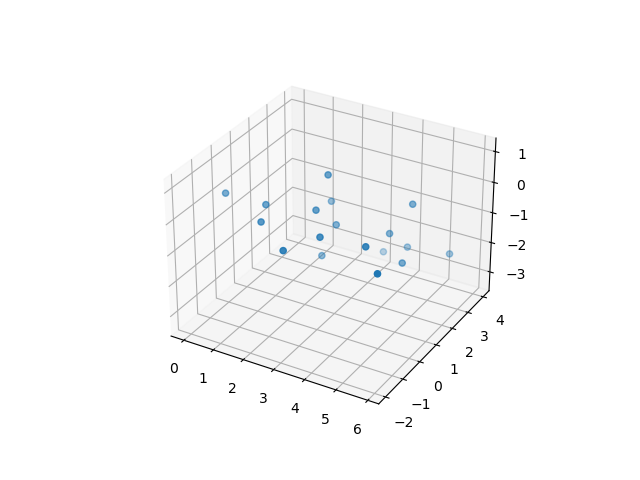

In [1024]:

%matplotlib widget
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# ax.plot(*np.vstack([a1,np.zeros(3),a2, n1]).T)
# ax.plot(*np.vstack([a1,np.zeros(3),a2, n2]).T)
ax.scatter(x,y,z)
ax.set_aspect('equal', 'box')
plt.show()

In [980]:
res.missing_atoms

['HN', 'HA', 'HB1', 'HB2', 'HG1', 'HG2']

In [1015]:
hydrogen_seq

[('HN', ('-C', 'CA', 'N', 'HN')),
 ('HA', ('N', 'C', 'CA', 'HA')),
 ('HB1', ('CG', 'CA', 'CB', 'HB1')),
 ('HB2', ('CG', 'CA', 'CB', 'HB2')),
 ('HG1', ('CD', 'CB', 'CG', 'HG1')),
 ('HG2', ('CD', 'CB', 'CG', 'HG2'))]

In [1017]:
find_coords_by_ic(hydrogen_seq, ic_dicts, coord_dict)

{'HN': array([ 1.75209154e+00, -9.10053329e-01,  5.60467207e-16]),
 'HA': array([2.66897408, 1.21904804, 0.73964641]),
 'HB1': array([ 2.06010874,  2.45869174, -0.87187482]),
 'HB2': array([ 2.3628279 ,  1.37939871, -2.07275694]),
 'HG1': array([ 4.87622447,  1.61062696, -1.69571516]),
 'HG2': array([ 4.58791746,  2.73263479, -0.40125037])}

In [1016]:
heavy_seq

[('C', ('-C', 'N', 'CA', 'C')),
 ('+N', ('N', 'CA', 'C', '+N')),
 ('O', ('+N', 'CA', 'C', 'O')),
 ('+CA', ('CA', 'C', '+N', '+CA')),
 ('CB', ('N', 'C', 'CA', 'CB')),
 ('CG', ('N', 'CA', 'CB', 'CG')),
 ('CD', ('CA', 'CB', 'CG', 'CD')),
 ('OE1', ('CB', 'CG', 'CD', 'OE1')),
 ('OE2', ('OE1', 'CG', 'CD', 'OE2'))]

In [607]:
all_ic_ids = []
for atom_name in all_atoms:
    all_ic_ids.extend(lookup_dict[atom_name])

In [545]:
H_ic = []
for atom_name in all_hydrogen:
    H_ic.extend(lookup_dict[atom_name])

In [535]:
heavy_ic = []
for atom_name in all_heavy:
    heavy_ic.extend(lookup_dict[atom_name])

In [609]:
all_ic_ids

[0, 1, 0, 2, 3, 3, 4, 5, 12, 13, 6, 7, 8, 9, 8, 9, 10, 11, 12, 13, 12, 13]

In [140]:
coords = np.empty((4,3))

In [142]:
coords[0] = np.zeros(3)

In [143]:
coords[1] = 

array([[0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 1.03977794e-312, 1.09751558e-071],
       [5.40030824e-062, 4.85197398e-033, 6.23749263e-042],
       [8.67638422e-067, 4.04188538e-037, 8.60641666e-043]])

In [153]:
np.arctan2(1,2)

0.4636476090008061

In [262]:
for atom in res:
    print(atom.name, atom.coord)

N [ 87.515  33.367 -10.906]
CA [ 87.998  34.689 -10.443]
C [87.888 34.743 -8.926]
O [87.341 33.822 -8.327]
CB [ 87.137  35.787 -11.051]


In [178]:
x, y, z = np.vstack([res['N'].coord, res['CA'].coord, res['CB'].coord]).T

In [358]:
CG2 = get_coord_from_improper_ic(OG1,res['CA'].coord,res['CB'].coord,thr_ic[9])

In [359]:
CG2

array([ 87.00470614,  35.83937633, -12.57678007])

In [345]:
thr_ic[9]

{'I': 'OG1',
 'J': 'CA',
 'K': '*CB',
 'L': 'CG2',
 'R(I-K)': 1.4252,
 'T(I-K-J)': 112.16,
 'Phi': -124.13,
 'T(J-K-L)': 115.91,
 'R(K-L)': 1.5324}

In [353]:
OG1 = get_coord_from_chain_ic(
    res['N'].coord, res['CA'].coord, res['CB'].coord, thr_ic[7]
)

In [341]:
HG1 = get_coord_from_chain_ic(
    res['CA'].coord, res['CB'].coord, OG1, thr_ic[10]
)

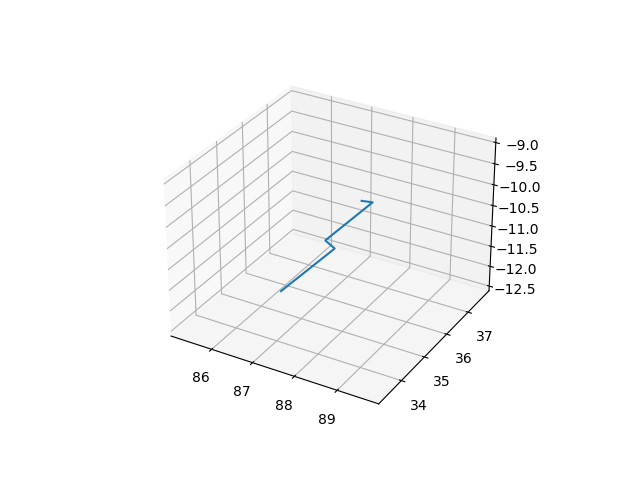

In [343]:
x, y, z = np.vstack([res['N'].coord, res['CA'].coord, res['CB'].coord, result_coord, HG1]).T

%matplotlib widget
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# ax.plot(*np.vstack([a1,np.zeros(3),a2, n1]).T)
# ax.plot(*np.vstack([a1,np.zeros(3),a2, n2]).T)
ax.plot(x,y,z)
ax.set_aspect('equal', 'box')
plt.show()